In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, date
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from datetime import time
from datetime import datetime, timedelta

In [2]:
# read the data
df_gps = pd.read_excel("Radiosonde/GpsResults.xlsx")
df_ptu = pd.read_excel("Radiosonde/PtuResults.xlsx")

In [3]:
# function to calculate the height from the pressure, with hydrostatic approximation
def height_from_pressure(p2, p1=1007,rho=1.15, g=9.81):
    dp = p1 - p2
    dz = dp / (rho * g)
    return dz

## WXT data

In [4]:
df_wxt = pd.read_csv("Data_WXT/20250827.txt", skiprows=6, delimiter=';')

In [5]:
df_wxt

,$Names=DATE,TIME,PTB_LAT,PTB_LON,PTB_ALT,PTB_SMP,PTB_P
0,27.08.2025,00:00,NaN,NaN,NaN,5.5500,1010.134
1,27.08.2025,00:01,NaN,NaN,NaN,5.5500,1010.112
2,27.08.2025,00:02,NaN,NaN,NaN,5.5500,1010.093
3,27.08.2025,00:03,NaN,NaN,NaN,5.5500,1010.073
4,27.08.2025,00:04,NaN,NaN,NaN,5.5500,1010.053
...,...,...,...,...,...,...,...
1435,27.08.2025,23:55,NaN,NaN,NaN,5.5667,1007.691
1436,27.08.2025,23:56,NaN,NaN,NaN,5.5500,1007.690
1437,27.08.2025,23:57,NaN,NaN,NaN,5.5500,1007.680
1438,27.08.2025,23:58,NaN,NaN,NaN,5.5500,1007.679


## Plots from GPS data

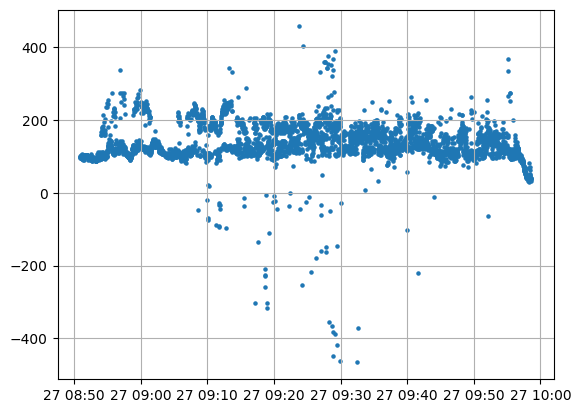

In [6]:
# plot Altitude from GPS
# plt.scatter(df_gps['Time'][1:],df_gps['Altitude'][1:], marker='o', s=5)
plt.scatter(df_gps['Time'][1397:],df_gps['Altitude'][1397:], marker='o', s=5)
plt.grid();

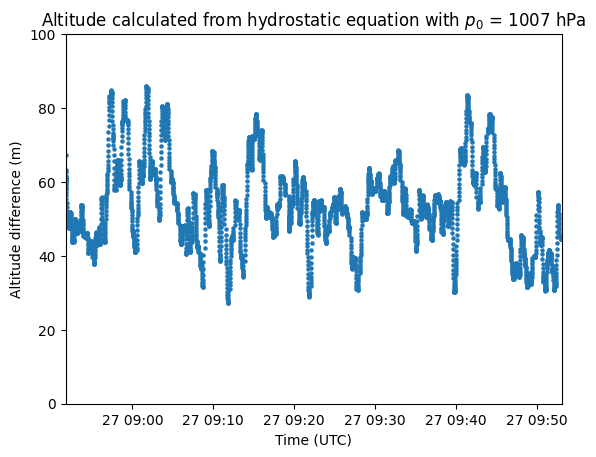

In [7]:
# plot altitude from hydrostatic approximation
fig = plt.figure()
plt.scatter(df_ptu['Time'][1:3683],height_from_pressure(df_ptu['Pressure'][1:3683])*100, marker='o', s=5)
plt.xlim(df_ptu['Time'][1], df_ptu['Time'][3683])
plt.ylim(0,100)
plt.title(r'Altitude calculated from hydrostatic equation with $p_0$ = 1007 hPa')
plt.ylabel('Altitude difference (m)')
plt.xlabel('Time (UTC)')
plt.show()
fig.savefig('Plots/20250827_Radiosonde_altitude.png', dpi=300)

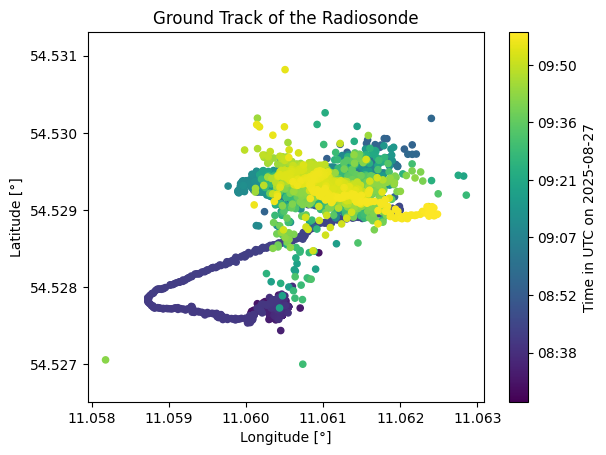

In [8]:
# plot ground track
time_num = mdates.date2num(df_gps['Time'][1:])  # convert to float

fig = plt.figure()
sc = plt.scatter(df_gps['Longitude'][1:], df_gps['Latitude'][1:], c=time_num, cmap="viridis", s=20)
plt.xlabel("Longitude [°]")
plt.ylabel("Latitude [°]")
plt.title("Ground Track of the Radiosonde")
plt.axis("equal")
cbar = plt.colorbar(sc, label="Time in UTC on 2025-08-27")
cbar.ax.yaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.show()
fig.savefig('Plots/20250827_Radiosonde_ground_track.png', dpi=300)

## Plots from PTU data

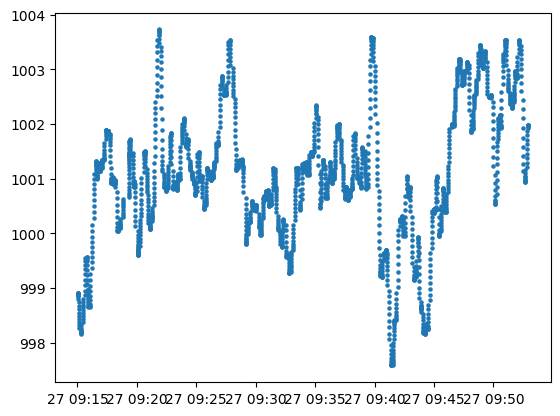

In [9]:
# plot the Pressure
#plt.scatter(df_ptu['Time'][1:],df_ptu['Pressure'][1:], marker='o', s=5)
plt.scatter(df_ptu['Time'][1397:3683],df_ptu['Pressure'][1397:3683], marker='o', s=5);

## Theodolite data

In [10]:
theo = pd.read_csv("Data_Theodolite/theodolite_202508271110_202508271153.csv")

In [11]:
start_time = datetime(2025, 8, 27, 11, 8, 9)

In [12]:
file_path = "Data_Theodolite/TheoRot_20250827_150544.txt"

# Read all lines first
with open(file_path, "r") as f:
    lines = f.readlines()
# Skip last three lines
lines = lines[:-3]
# Lists to store data
time_sec = []
value1 = []
value2 = []

for line in lines:
    line = line.strip()
    if line.startswith("D"):  # data line
        parts = line.split()
        time_sec.append(float(parts[1]))
        value1.append(float(parts[2]))
        value2.append(float(parts[3]))
    elif line.startswith("S"):
        print("Metadata:", line)  # optional

azimuth = np.array(value1) + (231.1-123.93)
azimuth[azimuth > 360] = azimuth[azimuth > 360] - 360
# Create DataFrame
df_theo = pd.DataFrame({
    "time_sec": [start_time + timedelta(seconds=s) for s in time_sec],
    "azimuth": azimuth,
    "elevation": value2})

Metadata: S 25/08/27 09:08:09


In [13]:
theo["real_azimuth"] = theo["azimuth"] + (231.1-123.93)  # correction term using the light house
# theo["real_azimuth"] = [t - 360. if t >= 360 else t for t in theo["real_azimuth"]]
theo["time"] = [datetime.strptime(d, "%H:%M").time() for d in theo["time"]]
theo["time"] = [datetime.combine(date(2025,8,27), t) for t in theo["time"]]

In [18]:
real_azimuth2

0     342.88
1     346.51
2     338.93
3     348.65
4     351.10
5     333.62
6     340.22
7     348.71
8     340.58
9     333.44
10    337.23
11   -192.83
12    349.80
13    351.27
14    350.30
15    350.29
16    343.41
17    353.47
18      5.23
19    345.17
20    345.94
21    349.59
22    359.61
23    358.08
24    349.06
25    354.76
26    354.00
27    344.23
28    343.68
29    351.54
Name: real_azimuth, dtype: float64

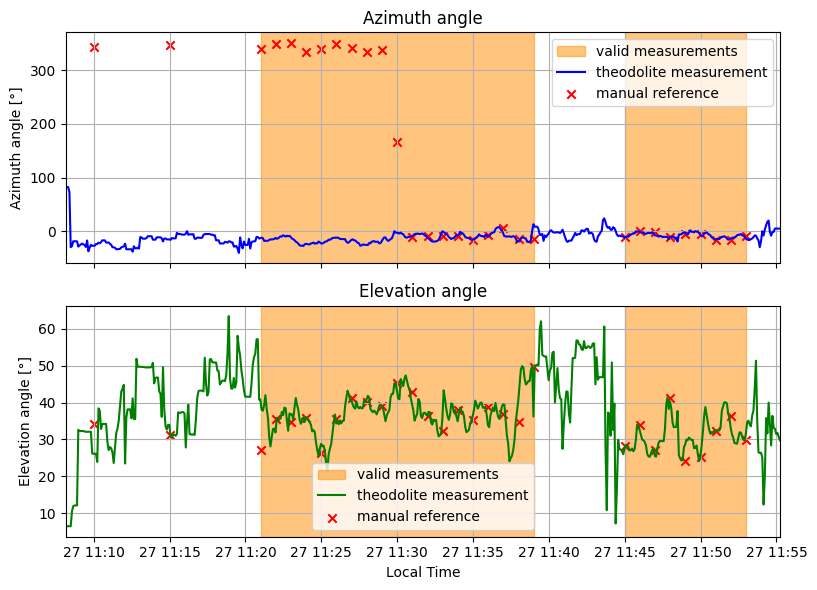

In [19]:
# start at index number 84 (or later)
valid1 = datetime(2025, 8, 27, 11, 21, 0)  # 2025-08-27 11:21:00
valid2 = datetime(2025, 8, 27, 11, 39, 0)  # 2025-08-27 11:39:00
valid3 = datetime(2025, 8, 27, 11, 45, 0)  # 2025-08-27 11:21:00
valid4 = datetime(2025, 8, 27, 11, 53, 0)  # 2025-08-27 11:39:00
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# First subplot: value1 vs time
angles_unwrapped = np.rad2deg(np.unwrap(np.deg2rad(df_theo['azimuth'])))
real_azimuth2 = theo["real_azimuth"].copy()
real_azimuth2[real_azimuth2 > 360] = real_azimuth2[real_azimuth2 > 360] - 360
angles_unwrapped_manual = np.rad2deg(np.unwrap(np.deg2rad(real_azimuth2)))
yticks = [-40, -20, 0, 20, 40, 60, 80]
ytick_labels = [320, 340, 0, 20, 40, 60, 80]
ax1.axvspan(valid1,valid2, color='darkorange', alpha=0.5, label='valid measurements')
ax1.axvspan(valid3,valid4, color='darkorange', alpha=0.5)
ax1.plot(df_theo['time_sec'], angles_unwrapped, color="blue", label='theodolite measurement')
ax1.scatter(theo["time"], angles_unwrapped_manual, label='manual reference', marker = 'x', color='red')
ax1.set_ylabel("Azimuth angle [°]")
ax1.set_title("Azimuth angle")
#ax1.set_ylim(300, 400)
#ax1.set_yticks(yticks, ytick_labels)
ax1.legend()
ax1.grid(True)

# Second subplot: value2 vs time#
ax2.axvspan(valid1,valid2, color='darkorange', alpha=0.5, label='valid measurements')
ax2.axvspan(valid3,valid4, color='darkorange', alpha=0.5)
ax2.plot(df_theo['time_sec'], df_theo['elevation'], color="green",label='theodolite measurement')
ax2.scatter(theo["time"], theo["elevation"], label='manual reference', marker = 'x', color='red')
ax2.set_xlabel("Local Time")
ax2.set_ylabel("Elevation angle [°]")
ax2.set_title("Elevation angle")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.xlim(df_theo['time_sec'].iloc[0], df_theo['time_sec'].iloc[-1])
plt.show()

fig.savefig('Plots/20250827_Theodolite.png', dpi=300)